<a href="https://colab.research.google.com/github/HQhanqiZHQ/DL_labs/blob/main/ps2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework #2: Convolutional Neural Networks
Due date is on Canvas.
# You are required to upload a pdf of this notebook along with the ipynb file.
## Harvard ID: 81631239

## Question 1
(a) You have an input volume that is 15x15x8 and pad it using *p = 2*. What is the dimension of the resulting volume?


The new width is 15+22=19. The new height is 15+22=19. Depth remains the same. So, the dimension of the resulting volume is 19x19x8.

(b) You have an input volume that is 32x32x16 and apply max pooling with a stride of 2 and a filter of size of 2x2. What is the output volume?

(32-2)/2+1=16 The output volume is 16x16x16

(c) You have an input volume that is 63x63x16 and convolve it with 32 filters that are each 7x7, and a stride of 1. You want to use a "same" convolution. What is the padding *p*?

63 = (63+2p-7)/1+1 so, p= (7-1)/2=3

(d) You have an input volume that is 63x63x16 and convolve it with 32 filters that are each 7x7, using a stride of 2 and no padding. What is the output volume?

(63-7)/2+1=29 so, the new width is 29, and the new height is 29. The depth becomes the number of filter used. So, the output volume is 29x29x32.

## Question 2: Classification of Chest X-rays
Chest X-ray exams are one of the most frequent and cost-effective medical imaging examinations available. However, clinical diagnosis of a chest X-ray can be challenging and sometimes more difficult than diagnosis via chest CT imaging. The lack of large publicly available datasets with annotations means it is still very difficult, if not impossible, to achieve clinically relevant computer-aided detection and diagnosis (CAD) in real world medical sites with chest X-rays. One major hurdle in creating large X-ray image datasets is the lack resources for labeling so many images. Prior to the release of this dataset, Openi was the largest publicly available source of chest X-ray images with 4,143 images available.

This [NIH Chest X-ray Dataset](https://www.kaggle.com/nih-chest-xrays/data) is comprised of 112,120 X-ray images with disease labels from 30,805 unique patients. To create these labels, the authors used Natural Language Processing to text-mine disease classifications from the associated radiological reports. The labels are expected to be >90% accurate and suitable for weakly-supervised learning. The original radiology reports are not publicly available but you can find more details on the labeling process in this Open Access paper: "ChestX-ray8: Hospital-scale Chest X-ray Database and Benchmarks on Weakly-Supervised Classification and Localization of Common Thorax Diseases." (Wang et al.)

Here we will use a subset of the data, rather than all 112,120 images. The images have been split into training, validation and test sets, each with folders containing the images for a particular diagnosis (class). The full data set contains images with single labels and multi-lables, with a total of 15 unique diagnoses. Our subsample contains only single label images with a total of 7 diagnoses: atelectasis, effusion, infiltration, mass, nodule, none (no finding), and pneumothorax. Your task is to classify the images correctly by building multiple CNNs and comparing their performance.

Here are what a few of the X-rays look like:

![xrays](https://drive.google.com/uc?id=1m42zYcI1YWDn9TuBlA5vukN7rqaILuXF)

### Load the data

The data are available in Google Drive [here](https://drive.google.com/open?id=1Q9DGe2-WcN1T5ToDLr4AMk-UAFedb309) or in Dropbox [here](https://www.dropbox.com/sh/6rstxss79669361/AABXuOWEA75MtWWTVeER4UeKa?dl=0). **Please note that if you are accessing the Google Drive folder that there are 2 xray datasets: `xrays` and `xrays-small`. You will use the `xrays` dataset for this assignment.**

Load the data and print the number of training, validation and test set examples there are of each class. Be sure to change the directory path provided below to your own data path.

In [4]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from tensorflow.keras import backend as K
from tensorflow.keras import datasets, layers, models
import os, shutil

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# Define directories of where the training, validation and test sets reside
# Heather's:
base_dir = 'drive/My Drive/BST261/xrays/'
# This is the path to where my files are - your path will be different, something like this:
# base_dir = 'drive/My Drive/Data/xrays/'

In [7]:
train_dir = os.path.join(base_dir, 'train_dir')
validation_dir = os.path.join(base_dir, 'validation_dir')
test_dir = os.path.join(base_dir, 'test_dir')

# Training Data
train_atelectasis  = os.path.join(train_dir, 'atelectasis')
train_effusion     = os.path.join(train_dir, 'effusion')
train_infiltration = os.path.join(train_dir, 'infiltration')
train_mass         = os.path.join(train_dir, 'mass')
train_nodule       = os.path.join(train_dir, 'nodule')
train_none         = os.path.join(train_dir, 'none')
train_pneumothorax = os.path.join(train_dir, 'pneumothorax')

# Validation Data
val_atelectasis  = os.path.join(validation_dir, 'atelectasis')
val_effusion     = os.path.join(validation_dir, 'effusion')
val_infiltration = os.path.join(validation_dir, 'infiltration')
val_mass         = os.path.join(validation_dir, 'mass')
val_nodule       = os.path.join(validation_dir, 'nodule')
val_none         = os.path.join(validation_dir, 'none')
val_pneumothorax = os.path.join(validation_dir, 'pneumothorax')

# Test Data
test_atelectasis  = os.path.join(test_dir, 'atelectasis')
test_effusion     = os.path.join(test_dir, 'effusion')
test_infiltration = os.path.join(test_dir, 'infiltration')
test_mass         = os.path.join(test_dir, 'mass')
test_nodule       = os.path.join(test_dir, 'nodule')
test_none         = os.path.join(test_dir, 'none')
test_pneumothorax = os.path.join(test_dir, 'pneumothorax')

Use the code below to check how many images are available for each class for the 3 sets (training, validation and testing) of images.

In [9]:
print('Total training atelectasisat images:', len(os.listdir(train_atelectasis)))
print('Total training effusion images:', len(os.listdir(train_effusion)))
print('Total training infiltration images:', len(os.listdir(train_infiltration)))
print('Total training mass images:', len(os.listdir(train_mass)))
print('Total training nodule images:', len(os.listdir(train_nodule)))
print('Total training no finding images:', len(os.listdir(train_none)))
print('Total training pneumothorax images:', len(os.listdir(train_pneumothorax)))

Total training atelectasisat images: 400
Total training effusion images: 400
Total training infiltration images: 400
Total training mass images: 200
Total training nodule images: 300
Total training no finding images: 400
Total training pneumothorax images: 300


In [10]:
print('Total validation atelectasisat images:', len(os.listdir(val_atelectasis)))
print('Total validation effusion images:', len(os.listdir(val_effusion)))
print('Total validation infiltration images:', len(os.listdir(val_infiltration)))
print('Total validation mass images:', len(os.listdir(val_mass)))
print('Total validation nodule images:', len(os.listdir(val_nodule)))
print('Total validation no finding images:', len(os.listdir(val_none)))
print('Total validation pneumothorax images:', len(os.listdir(val_pneumothorax)))

Total validation atelectasisat images: 100
Total validation effusion images: 100
Total validation infiltration images: 100
Total validation mass images: 55
Total validation nodule images: 70
Total validation no finding images: 100
Total validation pneumothorax images: 70


In [11]:
print('Total test atelectasisat images:', len(os.listdir(test_atelectasis)))
print('Total test effusion images:', len(os.listdir(test_effusion)))
print('Total test infiltration images:', len(os.listdir(test_infiltration)))
print('Total test mass images:', len(os.listdir(test_mass)))
print('Total test nodule images:', len(os.listdir(test_nodule)))
print('Total test no finding images:', len(os.listdir(test_none)))
print('Total test pneumothorax images:', len(os.listdir(test_pneumothorax)))

Total test atelectasisat images: 100
Total test effusion images: 100
Total test infiltration images: 100
Total test mass images: 55
Total test nodule images: 70
Total test no finding images: 100
Total test pneumothorax images: 70


### A. Build a CNN from scratch
Build a shallow (2-4 convolution layers) CNN. You are free to choose any values you wish for the filter size(s), pooling window size(s), and activation function(s). Please use an input shape of 64 x 64 and note that while these images look like greyscale images, they are in fact color images. Include a dense layer on top along with an appropriate output layer (number of neurons and activation function). Be sure to also include the `model.compile` function with an appropriate choice of loss function and performance metric.

In [12]:
# Your code here
# Define the model
model = models.Sequential()

# Convolutional layers
# First convolution layer with 32 filters, a kernel size of 3, using ReLU
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)))
model.add(layers.MaxPooling2D((2, 2)))
# Second convolution layer with 64 filteres, a kernal size of 3, using ReLU
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Flatten the output from convolutional layers to fully connected layers
model.add(layers.Flatten())

# A dense layer
# model.add(layers.Dropout(0.5))
model.add(layers.Dense(64, activation='relu'))

# Output layer for 7 classes, softmax for multi-class classification
model.add(layers.Dense(7, activation='softmax'))

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',  # Since it's a multi-class classification problem
              metrics=['accuracy'])

#### Define the image generator
Using the `ImageDataGenerator` function, create `train_datagen` and `test_datagen` generators that rescale the images appropriately. Then define a training set generator and validation set generator using the generators `train_datagen` and `test_datagen` and the `.flow_from_directory` function. Specify the `target_size` (it should match the input size above), set the `batch_size` to 20 and choose an appropriate `class_mode`.

In [13]:
# Your code here
from keras.preprocessing.image import ImageDataGenerator

# Rescale images
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Define batch size
batch_size = 20
# Define target size to match the input size
target_size = (64, 64)
# Define class mode for multi-class classification
class_mode = 'categorical'

# Training set generator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode=class_mode)
# Validation set generator
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode=class_mode)

Found 2400 images belonging to 7 classes.
Found 595 images belonging to 7 classes.


Use this code chunck to view the shapes of one batch of your training images and labels.

In [14]:
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (20, 64, 64, 3)
labels batch shape: (20, 7)


#### Compile your model
Be sure to choose appropriate numbers for the `steps_per_epoch` and `validation_steps` parameters. If one of the numbers is not a multiple of the batch size, round up to the nearest integer. Run this model for 30 epochs.

**Note: the first epoch will take about 15-20 minutes to run. The rest of the epochs will only take about a minute each to run.**

In [19]:
# Your code here
# Define steps_per_epoch and validation_steps
# Batch_size round up to the nearest integer
steps_per_epoch = train_generator.samples // batch_size
validation_steps = test_generator.samples // batch_size
if train_generator.samples % batch_size != 0:
    steps_per_epoch += 1
if test_generator.samples % batch_size != 0:
    validation_steps += 1

tf.random.set_seed(42)
# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=30,
    validation_data=test_generator,
    validation_steps=validation_steps)

Epoch 1/30
120/120 [==============================] - 598s 5s/step - loss: 1.9155 - accuracy: 0.2092 - val_loss: 1.9294 - val_accuracy: 0.2437
Epoch 2/30
120/120 [==============================] - 84s 697ms/step - loss: 1.7877 - accuracy: 0.2971 - val_loss: 1.9471 - val_accuracy: 0.2538
Epoch 3/30
120/120 [==============================] - 88s 733ms/step - loss: 1.7233 - accuracy: 0.3358 - val_loss: 1.9347 - val_accuracy: 0.2420
Epoch 4/30
120/120 [==============================] - 82s 688ms/step - loss: 1.6334 - accuracy: 0.3829 - val_loss: 1.9568 - val_accuracy: 0.2336
Epoch 5/30
120/120 [==============================] - 75s 624ms/step - loss: 1.5623 - accuracy: 0.4017 - val_loss: 2.0166 - val_accuracy: 0.2521
Epoch 6/30
120/120 [==============================] - 85s 709ms/step - loss: 1.4711 - accuracy: 0.4500 - val_loss: 2.0318 - val_accuracy: 0.2471
Epoch 7/30
120/120 [==============================] - 82s 681ms/step - loss: 1.3686 - accuracy: 0.4967 - val_loss: 2.1373 - val_accu

### Plot training and validation loss
Plot the training and validation loss. Does the model seem to be overfitting?


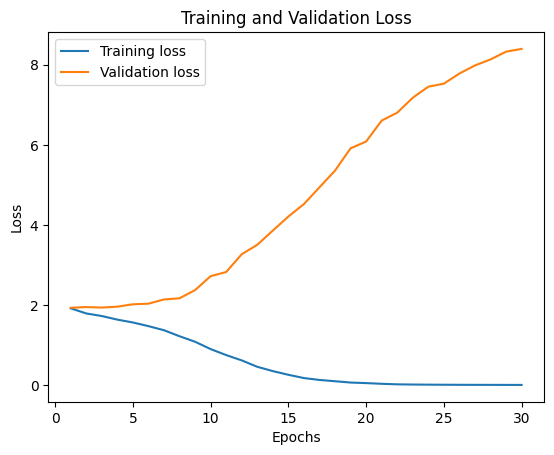

In [21]:
# Your code here
import matplotlib.pyplot as plt

# Extract the loss and validation loss
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Extract the number of epochs
epochs = range(1, len(train_loss) + 1)

# Plot training and validation loss
plt.plot(epochs, train_loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Yes. The training loss converages close to 0, and the validation loss does not converage and even increases as epochs increases. So, it shows that this model seems to be overfitting.

### Test accuracy
Calculate and report the test set accuracy.

In [22]:
# Your code here
_, test_accuracy = model.evaluate(test_generator, steps=validation_steps)
print("Test Accuracy:", test_accuracy)

30/30 [==============================] - 14s 453ms/step - loss: 8.3947 - accuracy: 0.2269
Test Accuracy: 0.22689075767993927


The test accuracy is 0.22689075767993927

### B. Using data augmentation
Using the same architecture above, fit the CNN using data augmentation. You are free to choose the type of transformations made to the training images, but keep `batch_size` equal to 20 and the `steps_per_epoch` the same as in part A. Be sure to include a `Dropout` layer before the first dense layer. Run this model for 30 epochs. **Note that this should take about an hour to run.**

Check out a few examples of augmented images with the code below.

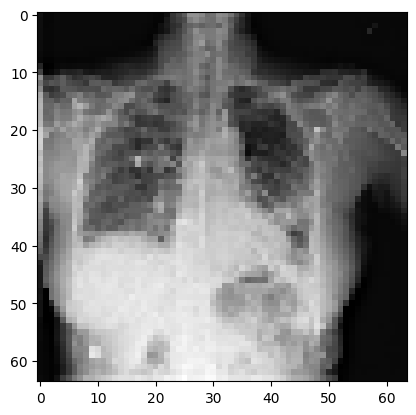

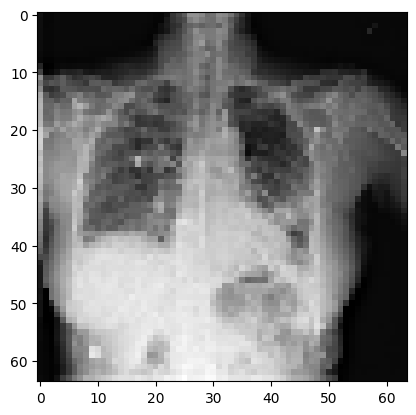

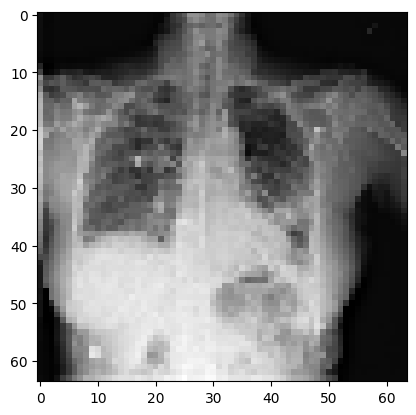

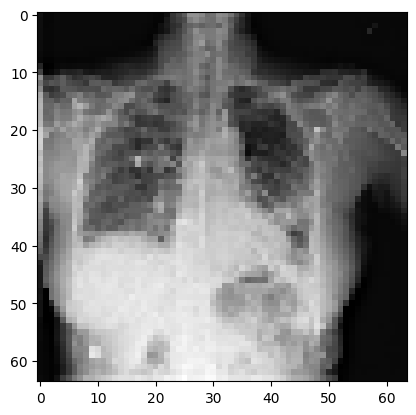

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
import os

# This is module with image preprocessing utilities
from keras.preprocessing import image

fnames = [os.path.join(train_nodule, fname) for fname in os.listdir(train_nodule)]

# We pick one image to "augment"
img_path = fnames[3]

# Read the image and resize it
img = image.load_img(img_path, target_size=(64, 64))

# Convert it to a Numpy array with shape (64, 64, 3)
x = image.img_to_array(img)

# Reshape it to (1, 64, 64, 3)
x = x.reshape((1,) + x.shape)

# The .flow() command below generates batches of randomly transformed images.
# It will loop indefinitely, so we need to `break` the loop at some point!
i = 0
for batch in train_datagen.flow(x, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 4 == 0:
        break

plt.show()

In [16]:
# Your code here (train_datagen)
# Rescale images and apply data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.2,1.2],
    shear_range=0.2,
    fill_mode='nearest')

In [17]:
# Your code here (train_generator)
# Training set generator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode=class_mode,
    seed = 42)

Found 2400 images belonging to 7 classes.


In [19]:
# Your code here (Train network)
steps_per_epoch = train_generator.samples // batch_size
validation_steps = test_generator.samples // batch_size
if train_generator.samples % batch_size != 0:
    steps_per_epoch += 1
if test_generator.samples % batch_size != 0:
    validation_steps += 1

tf.random.set_seed(42)
# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=30,
    validation_data=test_generator,
    validation_steps=validation_steps)

Epoch 1/30
120/120 [==============================] - 594s 5s/step - loss: 1.9347 - accuracy: 0.1679 - val_loss: 1.9304 - val_accuracy: 0.1916
Epoch 2/30
120/120 [==============================] - 94s 783ms/step - loss: 1.9260 - accuracy: 0.1758 - val_loss: 1.9268 - val_accuracy: 0.1983
Epoch 3/30
120/120 [==============================] - 94s 783ms/step - loss: 1.9214 - accuracy: 0.1921 - val_loss: 1.9235 - val_accuracy: 0.1748
Epoch 4/30
120/120 [==============================] - 86s 719ms/step - loss: 1.9192 - accuracy: 0.2037 - val_loss: 1.9164 - val_accuracy: 0.2252
Epoch 5/30
120/120 [==============================] - 87s 721ms/step - loss: 1.9106 - accuracy: 0.2175 - val_loss: 1.9083 - val_accuracy: 0.2286
Epoch 6/30
120/120 [==============================] - 96s 803ms/step - loss: 1.9022 - accuracy: 0.2237 - val_loss: 1.9047 - val_accuracy: 0.1950
Epoch 7/30
120/120 [==============================] - 89s 741ms/step - loss: 1.8904 - accuracy: 0.2362 - val_loss: 1.8830 - val_accu

#### Plot training and validation loss
Plot the training and validation loss. Does the model seem to be overfitting? Did data augmentation do anything to mitigate overfitting of the original model?


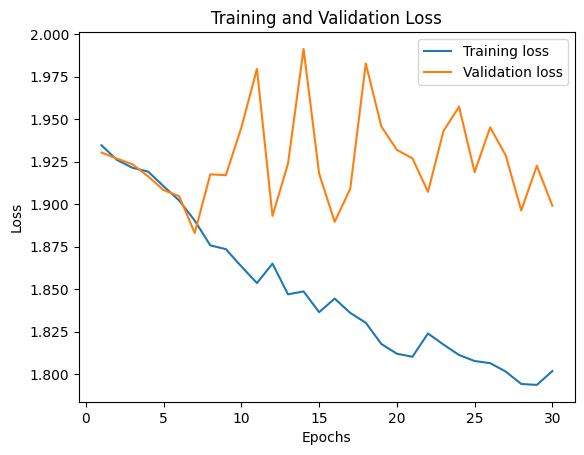

In [20]:
# Your code here
import matplotlib.pyplot as plt

# Extract the loss and validation loss
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Extract the number of epochs
epochs = range(1, len(train_loss) + 1)

# Plot training and validation loss
plt.plot(epochs, train_loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#### Test accuracy
Calculate and report the test set accuracy.

In [21]:
# Your code here
_, test_accuracy = model.evaluate(test_generator, steps=validation_steps)
print("Test Accuracy:", test_accuracy)

30/30 [==============================] - 15s 484ms/step - loss: 1.8991 - accuracy: 0.2353
Test Accuracy: 0.23529411852359772


The test set accuarcy is 0.23529411852359772

### C. Using a pretrained CNN without data augmentation

Use one of the pre-trained models in Keras that has been trained using the Imagenet data set as a convolutional base. Extract features by running your training set through the base.

In [22]:
# Your code here
from keras.applications import VGG16

# Load VGG16 pretrained model without the top classification layer
conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

# Without data augmentation here, rescale images directly
datagen = ImageDataGenerator(rescale=1./255)

# Create training set generator
train_generator = datagen.flow_from_directory(
    train_dir,
    target_size = target_size,
    batch_size = batch_size,
    class_mode= None)

# Extract features using pre-trained VGG16 model
features_test = conv_base.predict(test_generator, steps=len(test_generator))
features_train = conv_base.predict(train_generator, steps=len(train_generator))

# Flatten the output from convolutional layers to fully connected layers
features_train = np.reshape(features_train, (len(train_generator.filenames), 2 * 2 * 512))  # Adjust shape as per the last layer of the base model
features_test = np.reshape(features_test, (len(test_generator.filenames), 2 * 2 * 512))
print("Shape of extracted train features:", features_train.shape)
print("Shape of extracted test features:", features_test.shape)

58889256/58889256 [==============================] - 0s 0us/step
Found 2400 images belonging to 7 classes.
120/120 [==============================] - 162s 1s/step
Shape of extracted train features: (2400, 2048)
Shape of extracted test features: (595, 2048)


Take this output and train a classifier. You may use the classifier from previous parts of this question.

In [23]:
# Your code here
# Classifier from previous parts
classifier_model = models.Sequential()
classifier_model.add(layers.Dense(128, activation='relu', input_shape=(2 * 2 * 512,)))
classifier_model.add(layers.Dropout(0.5))
classifier_model.add(layers.Dense(64, activation='relu'))
classifier_model.add(layers.Dense(7, activation='softmax'))

tf.random.set_seed(42)
# Compile the model
classifier_model.compile(optimizer='adam',
                         loss='sparse_categorical_crossentropy',
                         metrics=['accuracy'])

history = classifier_model.fit(features_train, train_generator.classes,
                                epochs=30,
                                batch_size=batch_size,
                                validation_data=(features_test, test_generator.classes))

Epoch 1/30
120/120 [==============================] - 2s 9ms/step - loss: 1.9697 - accuracy: 0.1608 - val_loss: 1.9292 - val_accuracy: 0.1697
Epoch 2/30
120/120 [==============================] - 1s 7ms/step - loss: 1.9298 - accuracy: 0.1729 - val_loss: 1.9273 - val_accuracy: 0.1546
Epoch 3/30
120/120 [==============================] - 1s 6ms/step - loss: 1.9285 - accuracy: 0.1633 - val_loss: 1.9277 - val_accuracy: 0.1681
Epoch 4/30
120/120 [==============================] - 1s 8ms/step - loss: 1.9251 - accuracy: 0.1625 - val_loss: 1.9257 - val_accuracy: 0.1664
Epoch 5/30
120/120 [==============================] - 1s 11ms/step - loss: 1.9202 - accuracy: 0.1713 - val_loss: 1.9252 - val_accuracy: 0.1681
Epoch 6/30
120/120 [==============================] - 1s 10ms/step - loss: 1.9251 - accuracy: 0.1546 - val_loss: 1.9244 - val_accuracy: 0.1849
Epoch 7/30
120/120 [==============================] - 1s 11ms/step - loss: 1.9215 - accuracy: 0.1667 - val_loss: 1.9243 - val_accuracy: 0.1950
Epo

#### Plot training and validation loss
Plot the training and validation loss. Does the model seem to be overfitting? Does this model improve on the original model?

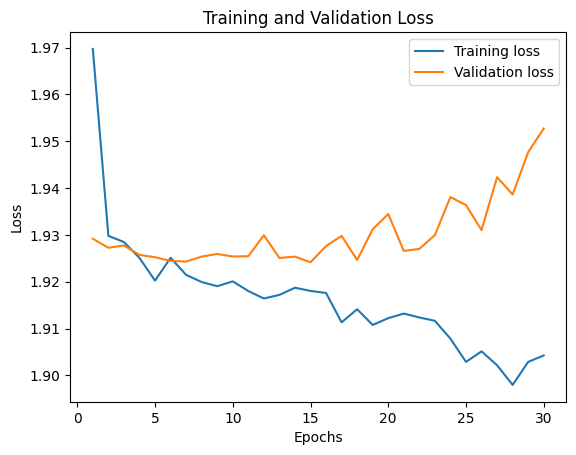

In [24]:
# Your code here
import matplotlib.pyplot as plt

# Extract the loss and validation loss
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Extract the number of epochs
epochs = range(1, len(train_loss) + 1)

# Plot training and validation loss
plt.plot(epochs, train_loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#### Test accuracy
Calculate and report the test set accuracy.

In [27]:
# Your code here
_, test_accuracy = classifier_model.evaluate(features_test, test_generator.classes)
print("Test Accuracy:", test_accuracy)

19/19 [==============================] - 0s 8ms/step - loss: 1.9527 - accuracy: 0.1429
Test Accuracy: 0.1428571492433548


The test set accuarcy is 0.1429.

### D. Summarize results
- Summarize the results from the 3 models you built. Which model would you choose to make future predictions?

Model A(without data augmentation) and B(with data augmentation) use our own version of CNN while Model C uses pre-trained model VGG16 to extract features of the original xray data and clssifies the images using a fully-connected head.

If we look at the test accuracy in these three models, we can see they respectively have test accuarcy 0.2269, 0.2353, 0.1429 (All very low) Based on this, I would choose Model B(with data augmentation) to make future predictions since its test accuary is the highest.


- List and describe at least 3 reasons for the poor performance of the models.

Inadequate Training Data: CNN typically require large training data. If the training data is not representative of the real-world scenario, lacks diversity, or is too small, the model may not be able to learn effectively.  This can lead to a model that performs well on training data but poorly on testing or real-world data, due to its inability to generalize. Maybe there are not enough data samples in each class for the model to learn from.

Data Quality Issues: If the medical images are not well-prepocessed or include incorrect data labels, this can lead to inaccurate models.

Models overfitting: As indicated in the plots, these models perform well in the training data with training loss converges to 0, however the validation loss keeps increasing, showing the models perform badly on the unseen data. This shows overfitting happens in these models.